In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import vstack, csr_matrix, csc_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [2]:
data_org = pd.read_csv("D:/STAT628m3/final_data1.csv")

In [22]:
data = data_org

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9700884 entries, 0 to 9700883
Data columns (total 34 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Year                              int64  
 1   Month                             int64  
 2   DayOfWeek                         int64  
 3   Operating_Airline                 object 
 4   Origin                            object 
 5   Dest                              object 
 6   DepDelay                          float64
 7   DepTimeBlk                        object 
 8   ArrDelay                          float64
 9   ArrTimeBlk                        object 
 10  Cancelled                         int64  
 11  ActualElapsedTime                 float64
 12  Distance                          int64  
 13  Origin_HourlyAltimeterSetting     float64
 14  Origin_HourlyDewPointTemperature  float64
 15  Origin_HourlyDryBulbTemperature   float64
 16  Origin_HourlyPrecipitation        fl

In [24]:
data['Holiday'].value_counts()

After Newyear                         3789945
Before Thanksgiving                   2428413
Between Thanksgiving and Christmas    2353942
Around Thanksgiving                    633570
Around Christmas                       263182
Around Newyear                         231832
Name: Holiday, dtype: int64

In [25]:
# calculate missing value ratio
missing_ratio = data.isna().mean() * 100

for column, ratio in missing_ratio.items():
    print(f"{column}: {ratio:.2f}%")

Year: 0.00%
Month: 0.00%
DayOfWeek: 0.00%
Operating_Airline : 0.00%
Origin: 0.00%
Dest: 0.00%
DepDelay: 1.92%
DepTimeBlk: 0.00%
ArrDelay: 1.97%
ArrTimeBlk: 0.00%
Cancelled: 0.00%
ActualElapsedTime: 1.97%
Distance: 0.00%
Origin_HourlyAltimeterSetting: 0.00%
Origin_HourlyDewPointTemperature: 0.00%
Origin_HourlyDryBulbTemperature: 0.00%
Origin_HourlyPrecipitation: 0.00%
Origin_HourlyRelativeHumidity: 0.00%
Origin_HourlySeaLevelPressure: 0.00%
Origin_HourlyVisibility: 0.00%
Origin_HourlyWindDirection: 0.00%
Origin_HourlyWindGustSpeed: 0.00%
Origin_HourlyWindSpeed: 0.00%
Dest_HourlyAltimeterSetting: 0.00%
Dest_HourlyDewPointTemperature: 0.00%
Dest_HourlyDryBulbTemperature: 0.00%
Dest_HourlyPrecipitation: 0.00%
Dest_HourlyRelativeHumidity: 0.00%
Dest_HourlySeaLevelPressure: 0.00%
Dest_HourlyVisibility: 0.00%
Dest_HourlyWindDirection: 0.00%
Dest_HourlyWindGustSpeed: 0.00%
Dest_HourlyWindSpeed: 0.00%
Holiday: 0.00%


In [26]:
data = data.drop(columns = "Year") 
data = data.drop(columns = "Month") 

data = data.drop(columns = "ArrDelay") 
data = data.drop(columns = "DepDelay") 
data = data.drop(columns = "ActualElapsedTime") 

# These two api could not be found
data = data.drop(columns = "Origin_HourlyAltimeterSetting") 
data = data.drop(columns = "Dest_HourlyAltimeterSetting") 

In [27]:
# data['Year']=data['Year'].astype('category')
# data['Month']=data['Month'].astype('category')
# data['DayofMonth']=data['DayofMonth'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
# data['Cancelled'] = data['Cancelled'].astype('category')

In [28]:
data["Origin_HourlyWindDirection"].value_counts()

Missing    1932875
230-270    1100904
140-180    1078774
0-40       1074348
270-310    1012769
320-350    1008084
180-220     975937
50-90       779495
90-130      668184
361          69514
Name: Origin_HourlyWindDirection, dtype: int64

In [29]:
continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [30]:
data = data.dropna()

In [31]:
data.isna().sum(axis=0)

DayOfWeek                           0
Operating_Airline                   0
Origin                              0
Dest                                0
DepTimeBlk                          0
ArrTimeBlk                          0
Cancelled                           0
Distance                            0
Origin_HourlyDewPointTemperature    0
Origin_HourlyDryBulbTemperature     0
Origin_HourlyPrecipitation          0
Origin_HourlyRelativeHumidity       0
Origin_HourlySeaLevelPressure       0
Origin_HourlyVisibility             0
Origin_HourlyWindDirection          0
Origin_HourlyWindGustSpeed          0
Origin_HourlyWindSpeed              0
Dest_HourlyDewPointTemperature      0
Dest_HourlyDryBulbTemperature       0
Dest_HourlyPrecipitation            0
Dest_HourlyRelativeHumidity         0
Dest_HourlySeaLevelPressure         0
Dest_HourlyVisibility               0
Dest_HourlyWindDirection            0
Dest_HourlyWindGustSpeed            0
Dest_HourlyWindSpeed                0
Holiday     

Split train & test, One Hot encode

In [32]:
X = data.drop(columns=['Cancelled'])
y = data['Cancelled']

In [33]:
categorical_features = X.select_dtypes(include=['category']).columns

In [34]:
categorical_features

Index(['DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest', 'DepTimeBlk',
       'ArrTimeBlk', 'Origin_HourlyWindDirection', 'Dest_HourlyWindDirection',
       'Holiday'],
      dtype='object')

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  
)
preprocessor.fit(X) 

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest', 'DepTimeBlk',
       'ArrTimeBlk', 'Origin_HourlyWindDirection', 'Dest_HourlyWindDirection',
       'Holiday'],
      dtype='object'))])

In [36]:
chunk_size = 500000 

X_transformed = csr_matrix((0, len(preprocessor.transform(X.iloc[:1]).toarray()[0])))

for start_row in range(0, len(X), chunk_size):
    end_row = min(start_row + chunk_size, len(X))
    data_chunk = X.iloc[start_row:end_row] 

    X_transformed_chunk = preprocessor.transform(data_chunk)

    print(f"Chunk shape: {X_transformed_chunk.shape}")

    X_transformed = vstack([X_transformed, X_transformed_chunk])

print(f"Transformed data shape: {X_transformed.shape}")

Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (200585, 886)
Transformed data shape: (9700585, 886)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=123)

In [38]:
categories = preprocessor.transformers_[0][1].categories_

encoded_feature_names = []
for feature, category in zip(categorical_features, categories):
    encoded_feature_names.extend([f"{feature}_{cat}" for cat in category])

numerical_feature_names_org = preprocessor.transformers_[1][2] if len(preprocessor.transformers_) > 1 else []
numerical_feature_names = []

for index in numerical_feature_names_org:
    if isinstance(index, int) and index < len(data.columns):
        numerical_feature_names.append(data.columns[index])
    else:
        numerical_feature_names.append(index)

all_feature_names = encoded_feature_names + numerical_feature_names

SMOTE (if necessary) (deal with training data only)

In [39]:
smote = SMOTE(sampling_strategy=1, random_state=123)

n_samples, n_features = X_train.shape

X_resampled = np.empty((0, n_features))
y_resampled = np.empty((0,))


for start in tqdm(range(0, n_samples, chunk_size)):
    end = min(start + chunk_size, n_samples)
    X_chunk = X_train[start:end]
    y_chunk = y_train[start:end]
    
    X_resampled_chunk, y_resampled_chunk = smote.fit_resample(X_chunk, y_chunk)
    
    print(f"Shape of X_resampled_chunk: {X_resampled_chunk.shape}")
    print(f"X_resampled.shape: {X_resampled.shape}")

    if isinstance(X_resampled_chunk, (csr_matrix, csc_matrix)):
        X_resampled = vstack([X_resampled, X_resampled_chunk])

    if X_resampled.shape[0] == 0:
        X_resampled = X_resampled_chunk
    
    y_resampled = np.concatenate((y_resampled, y_resampled_chunk))

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)

print("Class distribution after SMOTE:", Counter(y_resampled))

  0%|          | 0/16 [00:00<?, ?it/s]

Shape of X_resampled_chunk: (980308, 888)
X_resampled.shape: (0, 888)


  6%|▋         | 1/16 [00:29<07:20, 29.38s/it]

Shape of X_resampled_chunk: (980324, 888)
X_resampled.shape: (980308, 888)


 12%|█▎        | 2/16 [00:58<06:53, 29.50s/it]

Shape of X_resampled_chunk: (980370, 888)
X_resampled.shape: (1960632, 888)


 19%|█▉        | 3/16 [01:28<06:23, 29.51s/it]

Shape of X_resampled_chunk: (980580, 888)
X_resampled.shape: (2941002, 888)


 25%|██▌       | 4/16 [01:57<05:52, 29.40s/it]

Shape of X_resampled_chunk: (980082, 888)
X_resampled.shape: (3921582, 888)


 31%|███▏      | 5/16 [02:28<05:29, 29.91s/it]

Shape of X_resampled_chunk: (980060, 888)
X_resampled.shape: (4901664, 888)


 38%|███▊      | 6/16 [02:59<05:02, 30.29s/it]

Shape of X_resampled_chunk: (980048, 888)
X_resampled.shape: (5881724, 888)


 44%|████▍     | 7/16 [03:30<04:35, 30.56s/it]

Shape of X_resampled_chunk: (980096, 888)
X_resampled.shape: (6861772, 888)


 50%|█████     | 8/16 [04:02<04:07, 30.88s/it]

Shape of X_resampled_chunk: (980410, 888)
X_resampled.shape: (7841868, 888)


 56%|█████▋    | 9/16 [04:33<03:37, 31.02s/it]

Shape of X_resampled_chunk: (980140, 888)
X_resampled.shape: (8822278, 888)


 62%|██████▎   | 10/16 [05:06<03:08, 31.49s/it]

Shape of X_resampled_chunk: (980466, 888)
X_resampled.shape: (9802418, 888)


 69%|██████▉   | 11/16 [05:38<02:38, 31.67s/it]

Shape of X_resampled_chunk: (980240, 888)
X_resampled.shape: (10782884, 888)


 75%|███████▌  | 12/16 [06:10<02:07, 31.99s/it]

Shape of X_resampled_chunk: (980532, 888)
X_resampled.shape: (11763124, 888)


 81%|████████▏ | 13/16 [06:43<01:36, 32.03s/it]

Shape of X_resampled_chunk: (980310, 888)
X_resampled.shape: (12743656, 888)


 88%|████████▊ | 14/16 [07:16<01:04, 32.37s/it]

Shape of X_resampled_chunk: (980648, 888)
X_resampled.shape: (13723966, 888)


 94%|█████████▍| 15/16 [07:48<00:32, 32.47s/it]

Shape of X_resampled_chunk: (510600, 888)
X_resampled.shape: (14704614, 888)


100%|██████████| 16/16 [08:01<00:00, 30.08s/it]

Resampled X shape: (15215214, 888)
Resampled y shape: (15215214,)
Class distribution after SMOTE: Counter({0.0: 7607607, 1.0: 7607607})


regression without SMOTE

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

D:\Study\Conda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [44]:
from joblib import dump
import pickle

In [45]:
dump(model, "reg_nosmote_cancelled_model.joblib")

with open('reg_nosmote_cancelled_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [55]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"testing acc: {accuracy:.2f}")

testing acc: 0.98


In [56]:
y_pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"training acc: {accuracy_train:.2f}")

training acc: 0.98


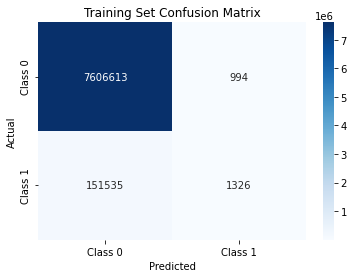

Training Set Confusion Matrix:
[[7606613     994]
 [ 151535    1326]]


In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set Confusion Matrix')
plt.show()

print("Training Set Confusion Matrix:")
print(cm)

In [49]:
# F1-score & ROC-AUC
y_prob_train = model.predict_proba(X_train)[:, 1]
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_prob_train)

print(f"F1-score of training: {f1_train}")
print(f"ROC-AUC of training: {roc_auc_train}")

F1-score of training: 0.01708972103543604
ROC-AUC of training: 0.7624624533607557


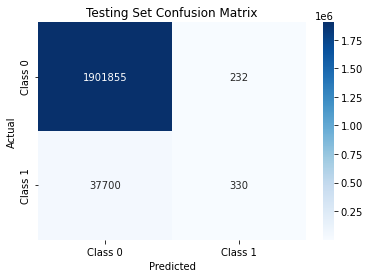

Testing Set Confusion Matrix:
[[1901855     232]
 [  37700     330]]


In [58]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing Set Confusion Matrix')
plt.show()

print("Testing Set Confusion Matrix:")
print(cm)

In [51]:
# F1-score & ROC-AUC
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"F1-score of testing: {f1}")
print(f"ROC-AUC of testing: {roc_auc}")

F1-score of testing: 0.017101990049751246
ROC-AUC of testing: 0.7622032998955101


In [52]:
coefficients = model.coef_.flatten()  

In [53]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

coef_df['Abs Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False)

In [59]:
coef_df_sorted.head(40)

,Feature,Coefficient,Abs Coefficient
863,Holiday_After Newyear,0.431110,0.431110
868,Holiday_Between Thanksgiving and Christmas,-0.326827,0.326827
31,Operating_Airline _WN,0.323968,0.323968
867,Holiday_Before Thanksgiving,-0.255922,0.255922
15,Operating_Airline _DL,-0.247364,0.247364
864,Holiday_Around Christmas,0.210117,0.210117
862,Dest_HourlyWindDirection_Missing,0.108849,0.108849
866,Holiday_Around Thanksgiving,-0.104469,0.104469
885,Dest_HourlyWindGustSpeed,0.101252,0.101252
9,Operating_Airline _AA,-0.098187,0.098187


regression with SMOTE

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
model = LogisticRegression(max_iter=500)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型准确率: 0.69


In [42]:
y_pred_train = model.predict(X_resampled)

accuracy_train = accuracy_score(y_resampled, y_pred_train)
print(f"Training set model accuracy: {accuracy_train:.2f}")

训练集模型准确率: 0.71


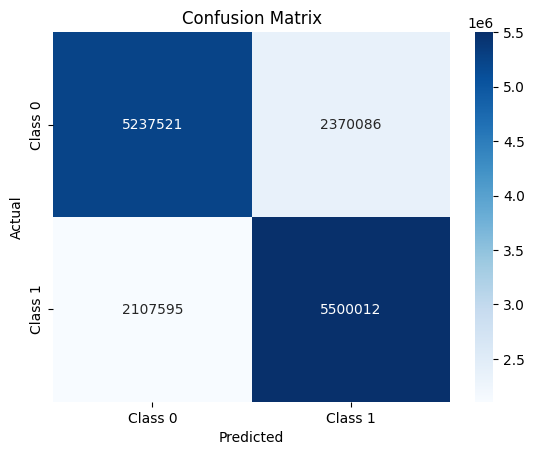

训练集Confusion Matrix:
[[5237521 2370086]
 [2107595 5500012]]


In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_resampled, y_pred_train)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set Confusion Matrix')
plt.show()

print("Training Set Confusion Matrix:")
print(cm)

In [44]:
from sklearn.metrics import f1_score, roc_auc_score

# F1-score & ROC-AUC
y_prob_train = model.predict_proba(X_resampled)[:, 1]
f1_train = f1_score(y_resampled, y_pred_train)
roc_auc_train = roc_auc_score(y_resampled, y_prob_train)

print(f"F1-score of training: {f1_train}")
print(f"ROC-AUC of training: {roc_auc_train}")

F1-score of training: 0.7107012312225875
ROC-AUC of training: 0.7757359099218241


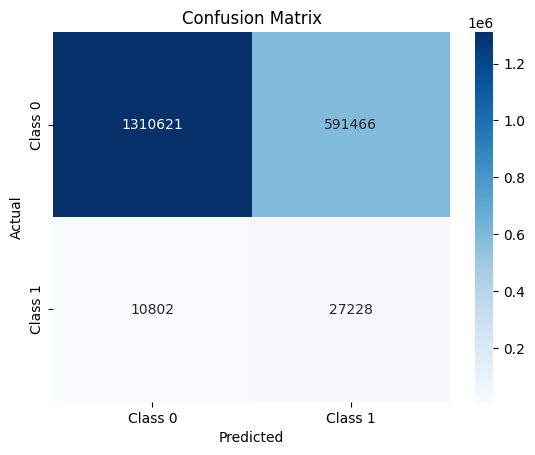

Confusion Matrix:
[[1310621  591466]
 [  10802   27228]]


In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing Set Confusion Matrix')
plt.show()

print("Testing Set Confusion Matrix:")
print(cm)

In [46]:
from sklearn.metrics import f1_score, roc_auc_score

# F1-score & ROC-AUC
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"F1-score of testing: {f1}")
print(f"ROC-AUC of testing: {roc_auc}")

F1-score of testing: 0.08292067900670601
ROC-AUC of testing: 0.7707321146792083


In [47]:
from scipy.sparse import csr_matrix

coefficients = model.coef_.flatten()  

In [48]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

coef_df['Abs Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False)

In [49]:
coef_df_sorted.head(30)

,Feature,Coefficient,Abs Coefficient
863,Holiday_After Newyear,0.832081,0.832081
31,Operating_Airline _WN,0.623475,0.623475
868,Holiday_Between Thanksgiving and Christmas,-0.616237,0.616237
867,Holiday_Before Thanksgiving,-0.560033,0.560033
864,Holiday_Around Christmas,0.442137,0.442137
15,Operating_Airline _DL,-0.410309,0.410309
862,Dest_HourlyWindDirection_Missing,0.226508,0.226508
9,Operating_Airline _AA,-0.212692,0.212692
852,Origin_HourlyWindDirection_Missing,0.193676,0.193676
866,Holiday_Around Thanksgiving,-0.187249,0.187249


LightGBM without SMOTE

In [35]:
params = {
    'objective': 'binary',       # Binary classification problem
    'metric': 'binary_error',    # Evaluation metric is error rate, but other metrics can also be used
    'boosting_type': 'gbdt',     # GBDT (Gradient Boosting Decision Tree)
    'num_leaves': 31,            # Typically, this value is around 31
    'learning_rate': 0.05,       # Learning rate
    'feature_fraction': 0.9,     # Feature subsampling ratio
    'bagging_fraction': 0.8,     # Data subsampling ratio
    'bagging_freq': 5,           # Perform data sampling every 5 iterations
    'verbose': -1,               # Suppress logging
    'is_unbalance': True,        # Automatically adjust class weights, equivalent to setting scale_pos_weight to 49.8 based on the formula above
    # 'scale_pos_weight': scale_pos_weight  # Set class weights
}


train_data = lgb.Dataset(X_train, label=y_train, feature_name=all_feature_names)
test_data = lgb.Dataset(X_test, label=y_test, feature_name=all_feature_names, reference=train_data)

In [36]:
clf = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],  
    num_boost_round=1000,     
)

In [37]:
y_pred_prob = clf.predict(X_test, num_iteration=clf.best_iteration)  
y_pred_prob_train = clf.predict(X_train, num_iteration=clf.best_iteration)  

In [38]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100)  
f1_scores = []

for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold}")

Optimal threshold: 0.8484848484848485


In [39]:
y_pred = (y_pred_prob > optimal_threshold).astype(int)  # Convert probabilities to classes (0 or 1)
y_pred_train = (y_pred_prob_train > optimal_threshold).astype(int)  # Convert probabilities to classes (0 or 1)

In [40]:
# F1-score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred)

print(f"Training set f1-score: {f1_train}")
print(f"Testing set f1-score: {f1_test}")

Training set f1-score: 0.33440233858885204
Testing set f1-score: 0.3288583184916784


In [41]:
# ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_prob_train)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Training set ROC-AUC: {roc_auc_train}")
print(f"Testing set ROC-AUC: {roc_auc}")

Training set ROC-AUC: 0.8938475020479205
Testing set ROC-AUC: 0.8847126864777792


In [42]:
from sklearn.metrics import accuracy_score

# acc
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred)

print(f"Training set accuracy: {acc_train}")
print(f"Testing set accuracy: {acc_test}")

Training set accuracy: 0.9718922879393356
Testing set accuracy: 0.97183623461884


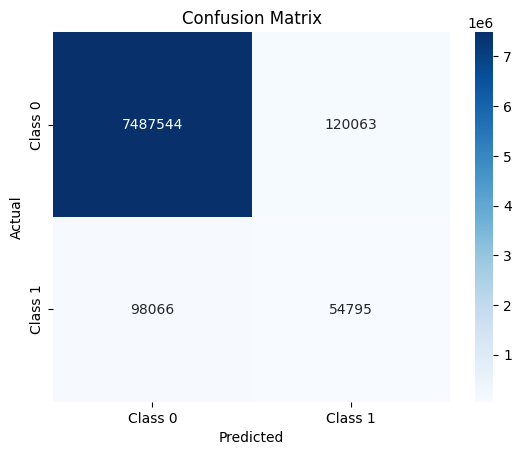

Training set Confusion Matrix:
[[7487544  120063]
 [  98066   54795]]


In [43]:
cm = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training set Confusion Matrix')
plt.show()

print("Training set Confusion Matrix:")
print(cm)

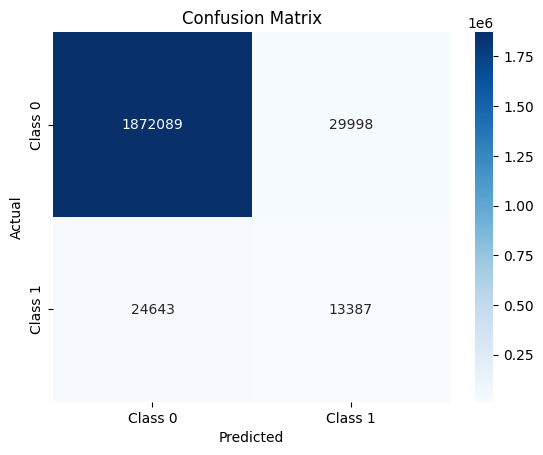

Testing set Confusion Matrix:
[[1872089   29998]
 [  24643   13387]]


In [44]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing set Confusion Matrix')
plt.show()

print("Testing set Confusion Matrix:")
print(cm)

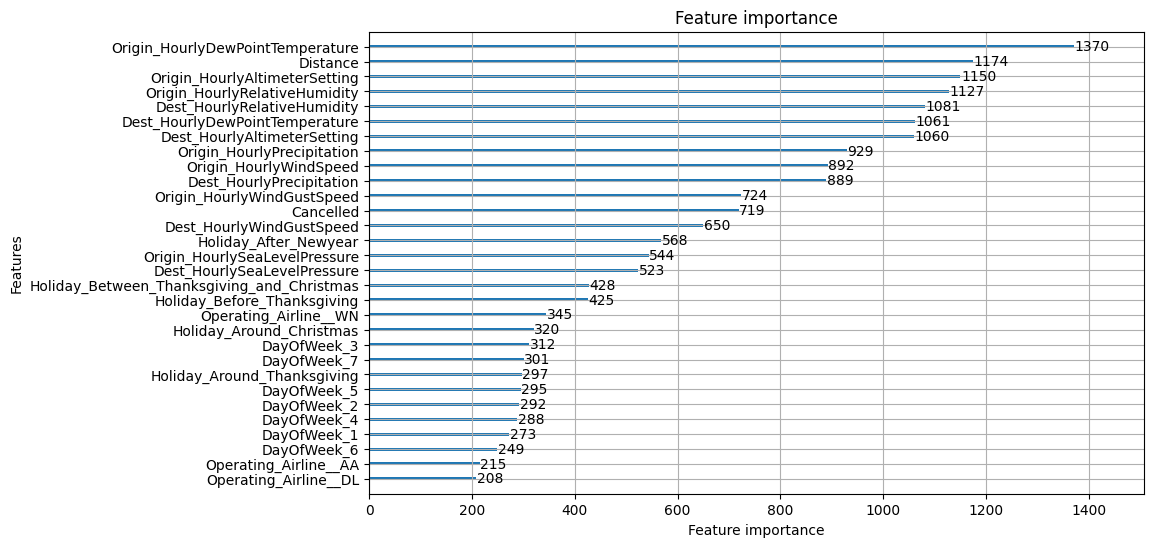

In [48]:
lgb.plot_importance(clf, max_num_features=30, importance_type='split', figsize=(10, 6))
plt.show()

LightGBM without onehot, without SMOTE

In [18]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=123)

In [19]:
params = {
    'objective': 'binary',       # Binary classification problem
    'metric': 'binary_error',    # Evaluation metric is error rate, but other metrics can also be used
    'boosting_type': 'gbdt',     # GBDT (Gradient Boosting Decision Tree)
    'num_leaves': 31,            # Typically, this value is around 31
    'learning_rate': 0.05,       # Learning rate
    'feature_fraction': 0.9,     # Feature subsampling ratio
    'bagging_fraction': 0.8,     # Data subsampling ratio
    'bagging_freq': 5,           # Perform data sampling every 5 iterations
    'verbose': -1,               # Suppress logging
    'is_unbalance': True,        # Automatically adjust class weights, equivalent to setting scale_pos_weight to 49.8 based on the formula above
    # 'scale_pos_weight': scale_pos_weight  # Set class weights
}


train_data1 = lgb.Dataset(X_train1, label=y_train1, feature_name=X.columns.tolist())
test_data1 = lgb.Dataset(X_test1, label=y_test1, feature_name=X.columns.tolist(), reference=train_data1)

In [20]:
clf1 = lgb.train(
    params,
    train_data1,
    valid_sets=[test_data1],  
    num_boost_round=1000   
)

In [21]:
y_pred_prob1 = clf1.predict(X_test1, num_iteration=clf1.best_iteration)  
y_pred_prob_train1 = clf1.predict(X_train1, num_iteration=clf1.best_iteration)  

In [22]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100) 
f1_scores = []

for t in thresholds:
    y_pred1 = (y_pred_prob1 >= t).astype(int)
    f1_scores.append(f1_score(y_test1, y_pred1))

optimal_threshold1 = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold1}")

Optimal threshold: 0.8686868686868687


In [23]:
y_pred1 = (y_pred_prob1 > optimal_threshold1).astype(int)  # Convert probabilities to classes (0 or 1)
y_pred_train1 = (y_pred_prob_train1 > optimal_threshold1).astype(int)  # Convert probabilities to classes (0 or 1)

In [24]:
# F1-score
f1_train1 = f1_score(y_train1, y_pred_train1)
f1_test1 = f1_score(y_test1, y_pred1)

print(f"Training set f1-score: {f1_train1}")
print(f"Testing set f1-score: {f1_test1}")

Training set f1-score: 0.37087100880588986
Testing set f1-score: 0.3483395029786782


In [25]:
# ROC-AUC
roc_auc_train1 = roc_auc_score(y_train1, y_pred_prob_train1)
roc_auc1 = roc_auc_score(y_test1, y_pred_prob1)

print(f"Training set ROC-AUC: {roc_auc_train1}")
print(f"Testing set ROC-AUC: {roc_auc1}")

Training set ROC-AUC: 0.9181846187155716
Testing set ROC-AUC: 0.8918923456171545


In [26]:
from sklearn.metrics import accuracy_score

# acc
acc_train1 = accuracy_score(y_train1, y_pred_train1)
acc_test1 = accuracy_score(y_test1, y_pred1)

print(f"Training set accuracy: {acc_train1}")
print(f"Testing set accuracy: {acc_test1}")

Training set accuracy: 0.9752906654598666
Testing set accuracy: 0.9746845164492657


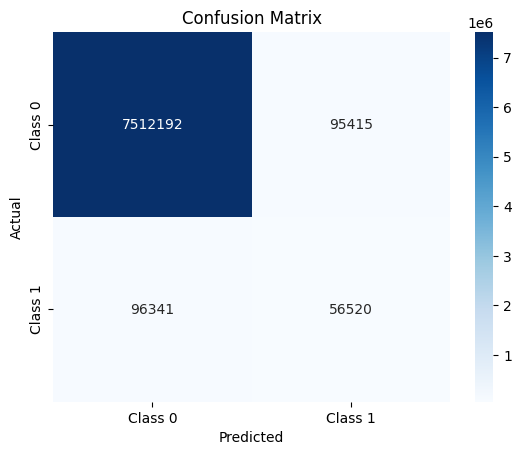

Training set Confusion Matrix:
[[7512192   95415]
 [  96341   56520]]


In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train1, y_pred_train1)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training set Confusion Matrix')
plt.show()

print("Training set Confusion Matrix:")
print(cm)

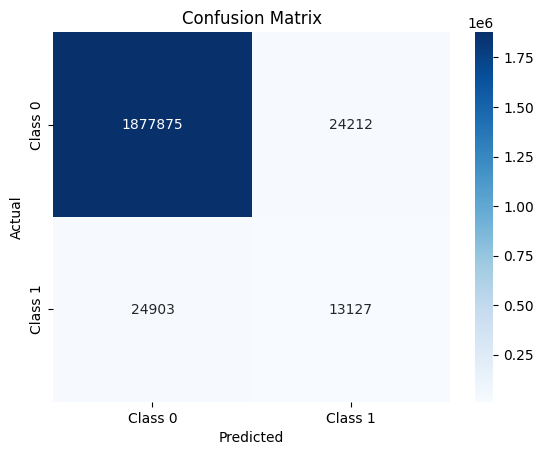

Testing set Confusion Matrix:
[[1877875   24212]
 [  24903   13127]]


In [29]:
cm = confusion_matrix(y_test1, y_pred1)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing set Confusion Matrix')
plt.show()

print("Testing set Confusion Matrix:")
print(cm)

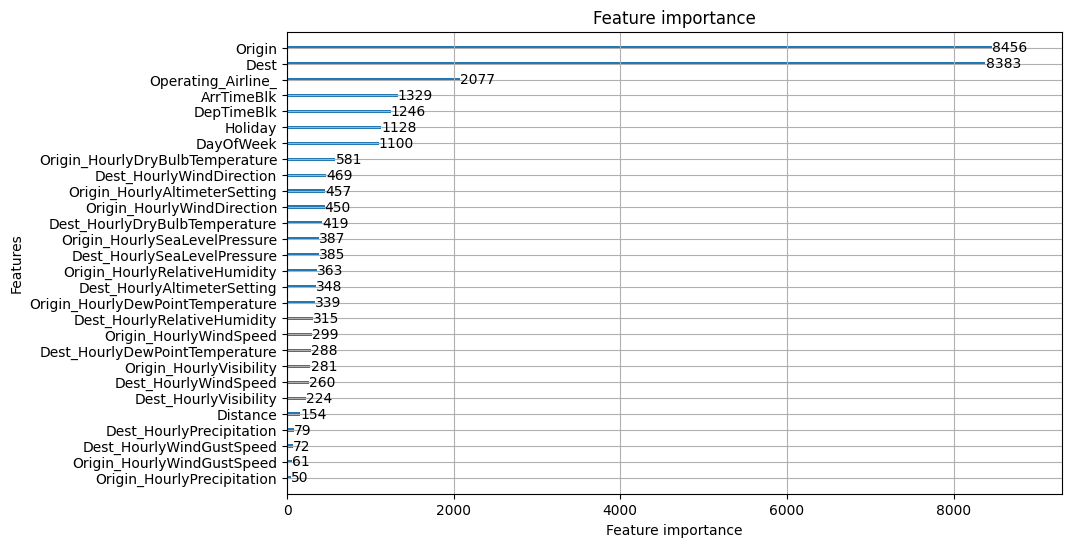

In [30]:
lgb.plot_importance(clf1, max_num_features=30, importance_type='split', figsize=(10, 6))
plt.show()

LightGBM with SMOTE

In [51]:
params = {
    'objective': 'binary',       # Binary classification problem
    'metric': 'binary_error',    # Evaluation metric is error rate, but other metrics can also be used
    'boosting_type': 'gbdt',     # GBDT (Gradient Boosting Decision Tree)
    'num_leaves': 31,            # Typically, this value is around 31
    'learning_rate': 0.05,       # Learning rate
    'feature_fraction': 0.9,     # Feature subsampling ratio
    'bagging_fraction': 0.8,     # Data subsampling ratio
    'bagging_freq': 5,           # Perform data sampling every 5 iterations
    'verbose': -1,               # Suppress logging
    'is_unbalance': True,        # Automatically adjust class weights, equivalent to setting scale_pos_weight to 49.8 based on the formula above
    # 'scale_pos_weight': scale_pos_weight  # Set class weights
}


train_data2 = lgb.Dataset(X_resampled, label=y_resampled, feature_name=all_feature_names)
test_data2 = lgb.Dataset(X_test, label=y_test, feature_name=all_feature_names, reference=train_data2)

In [52]:
clf2 = lgb.train(
    params,
    train_data2,
    valid_sets=[test_data2],  
    num_boost_round=1000
)

In [ ]:
y_pred_prob2 = clf2.predict(X_test, num_iteration=clf2.best_iteration) 
y_pred_prob_train2 = clf2.predict(X_resampled, num_iteration=clf2.best_iteration)  

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


In [ ]:
thresholds = np.linspace(0, 1, 100)  
f1_scores2 = []

for t in thresholds:
    y_pred2 = (y_pred_prob2 >= t).astype(int)
    f1_scores2.append(f1_score(y_test, y_pred2))

optimal_threshold2 = thresholds[np.argmax(f1_scores2)]
print(f"Optimal threshold: {optimal_threshold2}")

In [ ]:
y_pred2 = (y_pred_prob2 > optimal_threshold2).astype(int)  
y_pred_train2 = (y_pred_prob_train2 > optimal_threshold2).astype(int)  

In [ ]:
# F1-score
f1_train2 = f1_score(y_resampled, y_pred_train2)
f1_test2 = f1_score(y_test, y_pred2)

print(f"Training set f1-score: {f1_train2}")
print(f"Testing set f1-score: {f1_test2}")

In [ ]:
# ROC-AUC
roc_auc_train2 = roc_auc_score(y_resampled, y_pred_prob_train2)
roc_auc2 = roc_auc_score(y_test, y_pred_prob2)

print(f"Training set ROC-AUC: {roc_auc_train2}")
print(f"Testing set ROC-AUC: {roc_auc2}")

In [ ]:
# acc
acc_train2 = accuracy_score(y_resampled, y_pred_train2)
acc_test2 = accuracy_score(y_test, y_pred2)

print(f"Training set accuracy: {acc_train2}")
print(f"Testing set accuracy: {acc_test2}")

In [ ]:
cm = confusion_matrix(y_resampled, y_pred_train2)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training set Confusion Matrix')
plt.show()

print("Training set Confusion Matrix:")
print(cm)

In [ ]:
cm = confusion_matrix(y_test, y_pred2)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing set Confusion Matrix')
plt.show()

print("Testing set Confusion Matrix:")
print(cm)

In [ ]:
lgb.plot_importance(clf2, max_num_features=30, importance_type='split', figsize=(10, 6))
plt.show()
